# Notebook: pyolimp - Примеры симуляции

### 📦 Импорт библиотек

В этом разделе выполняется импорт необходимых модулей:

- `sys` — для добавления пути к корню проекта;
- `torch` — основная библиотека для работы с тензорами;
- `Tensor` — тип из `torch`, используемый для аннотирования аргументов;
- `matplotlib.pylab as plt` — модуль для построения графиков и отображения изображений;
- `pi` из `math` — значение числа π, может использоваться для дальнейших вычислений (хотя в текущей функции не используется).

In [4]:
import sys
sys.path.append("../../../")

In [5]:
import torch
from torch import Tensor
from matplotlib import pylab as plt
from math import pi

### 🖼️ Визуализация изображения

Функция `show_one` используется для отображения одного изображения с заголовком.  
Перед выводом она проверяет наличие `NaN` в тензоре, чтобы избежать ошибок отображения.

In [6]:
def show_one(image: Tensor, title: str) -> None:
    if image.isnan().any():
        raise ValueError("has nan")
    fig, ax1 = plt.subplots(dpi=72, figsize=(6, 4.5), ncols=1, nrows=1)
    plt.title(title)
    ax1.imshow(image)

### 🔍 Метод SCA (Simplified Conic Approximation)

Метод **SCA** — приближённая модель построения **Функции Рассеяния Точки (ФРТ)**  
для моделирования искажений изображения, вызванных аберрациями зрения.  
ФРТ формируется в виде **нормализованного эллипса**, параметры которого  
задаются сферической и цилиндрической составляющими, а также осью астигматизма.

#### 🧾 Вход:
- сферическая аберрация `sphere_dpt` (в диоптриях);
- цилиндрическая аберрация `cylinder_dpt` (в диоптриях);
- угол астигматизма `angle_rad` (в радианах);
- диаметр зрачка `pupil_diameter_mm` (в мм);
- масштаб `am2px` (угловые минуты в пиксели);
- размер ФРТ (ширина и высота, например 64×64 пикселя).

#### 📤 Выход:
- **ФРТ**: 2D тензор `Tensor[H, W]`,  
  значащий нормализованное распределение интенсивности,  
  задающее форму и направление искажений изображения.

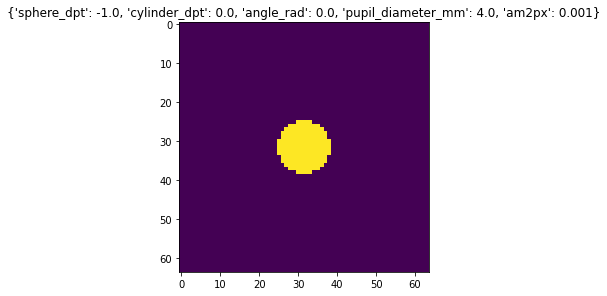

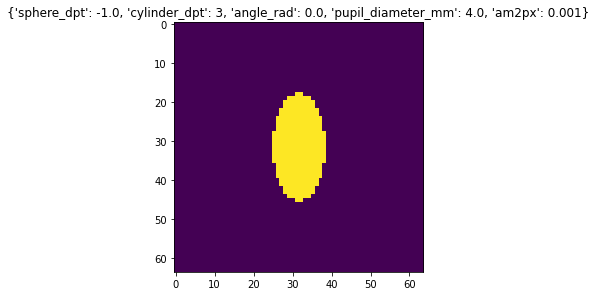

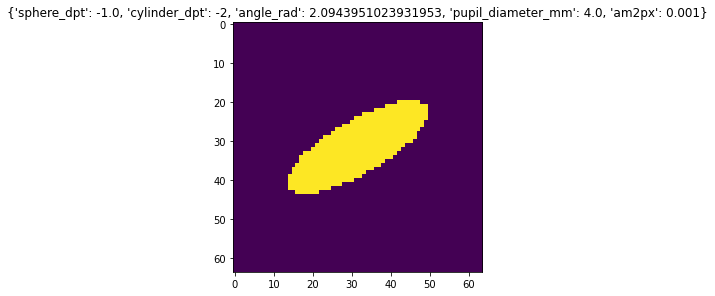

In [7]:
from olimp.simulate.psf_sca import PSFSCA


params = {
    "sphere_dpt": -1.0,
    "cylinder_dpt": 0.0,
    "angle_rad": 0.0,
    "pupil_diameter_mm": 4.0,
    "am2px": 0.001,
}

params1 = {**params}
show_one(PSFSCA(64, 64)(**params1), f"{params1}")
params2 = {**params, "cylinder_dpt": 3}
show_one(PSFSCA(64, 64)(**params2), f"{params2}")
params3 = {**params, "cylinder_dpt": -2, "angle_rad": pi / 1.5}
show_one(PSFSCA(64, 64)(**params3), f"{params3}")

### 🔍 Метод PSFGauss (Гауссовская функция рассеяния точки)

Метод **PSFGauss** используется для генерации **функции рассеяния точки (ФРТ)**  
в виде двумерного нормализованного **анизотропного гауссовского распределения**  
с возможностью задания ориентации эллипса и степени размытия по осям.

#### 🧾 Вход:
- `center_x`, `center_y` — координаты центра ФРТ (в пикселях);
- `sigma_x`, `sigma_y` — стандартные отклонения по осям X и Y (характеризуют размытие);
- `theta` — угол поворота эллипса (в радианах);
- размер ФРТ (ширина и высота, например 64×64 пикселя).

#### 📤 Выход:
- **ФРТ**: 2D тензор `Tensor[H, W]`,  
  представляющий собой нормализованную карту интенсивности рассеяния.

> Применяется для имитации искажений, аналогичных оптическому размытию в системах зрения и изображений.


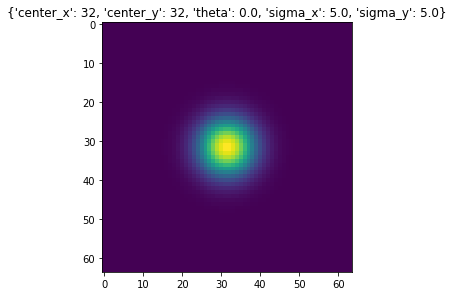

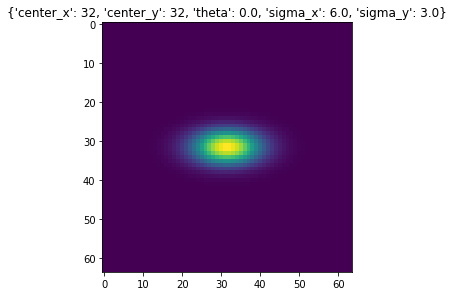

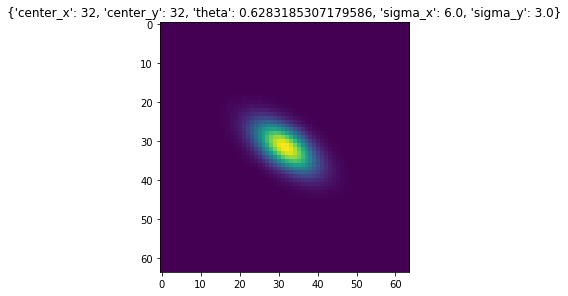

In [11]:
from olimp.simulate.psf_gauss import PSFGauss

params = {
    "center_x": 32,
    "center_y": 32,
    "theta": 0.0,
    "sigma_x": 5.0,
    "sigma_y": 5.0,
}

show_one(PSFGauss(64, 64)(**params), f"{params}")
params2 = {**params, "sigma_x": 6.0, "sigma_y": 3.0}
show_one(PSFGauss(64, 64)(**params2), f"{params2}")
params3 = {**params, "sigma_x": 6.0, "sigma_y": 3.0, "theta": pi / 5}
show_one(PSFGauss(64, 64)(**params3), f"{params3}")

### 👁 Метод RefractionDistortion

Класс **RefractionDistortion** моделирует искажения изображения, вызванные **рефракционными аномалиями** зрения,  
такими как близорукость, дальнозоркость и астигматизм. Метод реализует **свёртку изображения с ФРТ (PSF)**  
в частотной области, что позволяет точно смоделировать эффект, наблюдаемый на сетчатке глаза.

#### 🧾 Вход:
- Функция рассеяния точки `PSF` (тензор `Tensor[H, W]`), сдвинутая с помощью `fftshift`;
- Изображение (при вызове `RefractionDistortion()(image)` внутри пайплайна).

#### 📤 Выход:
- Искажённое изображение, имитирующее восприятие наблюдателем с заданными аберрациями.


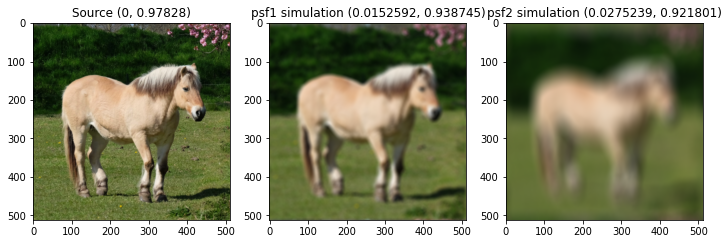

In [9]:
from olimp.simulate.refraction_distortion import RefractionDistortion
from olimp.simulate._demo_distortion import demo


def demo_simulate():
    psf1 = PSFSCA(512, 512)()
    yield RefractionDistortion()(torch.fft.fftshift(psf1)), "psf1"

    psf2 = PSFSCA(512, 512)(sphere_dpt=-3, cylinder_dpt=-2)
    yield RefractionDistortion()(torch.fft.fftshift(psf2)), "psf2"


demo("RefractionDistortion", demo_simulate, on="horse.jpg", size=(512, 512))

### 👁 Метод ColorBlindnessDistortion

Класс **ColorBlindnessDistortion** реализует симуляцию восприятия изображения людьми  
с различными типами **дальтонизма**. Основан на преобразовании изображения в цветовое пространство LMS  
и модификации компонент, имитирующих утрату чувствительности одного из трёх типов колбочек.

#### 🧾 Вход:
- Тип цветовой слепоты:
  - `"protan"` — протанопия (нечувствительность к красному);
  - `"deutan"` — дейтеранопия (нечувствительность к зелёному);
  - `"tritan"` — тританопия (нечувствительность к синему).

#### 📤 Выход:
- Искажённое изображение, соответствующее восприятию человека с указанным типом дальтонизма.

/home/devel9393/projects/pyolimp/docs/source/notebooks/../../../olimp/evaluation/cs/linrgb.py:35: UserWarning: sRGB range should be in [0, 1] not [0.1196029856801033, 1.000000238418579]
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.119602986..1.0000002].


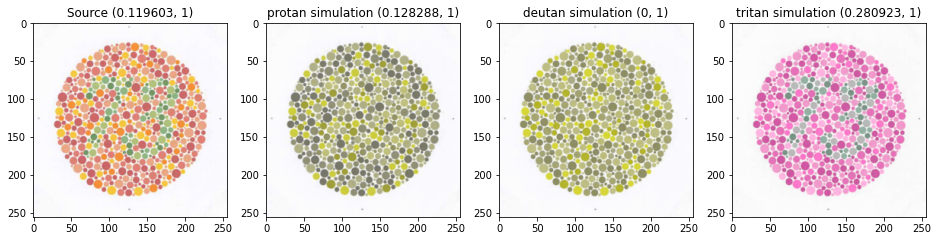

In [10]:
from olimp.simulate.color_blindness_distortion import ColorBlindnessDistortion


def demo_simulate():
    yield ColorBlindnessDistortion.from_type("protan")(), "protan"
    yield ColorBlindnessDistortion.from_type("deutan")(), "deutan"
    yield ColorBlindnessDistortion.from_type("tritan")(), "tritan"


demo("ColorBlindnessDistortion", demo_simulate)